In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pysindy as ps
from tqdm import tqdm
from joblib import Parallel, delayed
%matplotlib inline

### Task 1.1 Reconstructing a dynamical system from data using PySINDy

In [2]:
# Lorenz system
def lorenz_system(t, y, sigma=10, rho=28, beta=8/3):
    x, y, z = y
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [3]:
# Generate data
t_span = (0, 30)
n_steps = 3000
initial_conditions = [1.0, 1.0, 1.0]
t_eval = np.linspace(t_span[0], t_span[1], n_steps)
sol = solve_ivp(lorenz_system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

### Task 1.2 Fitting a model

In [4]:
# Initialize a SINDy model
feature_library = ps.PolynomialLibrary(degree=6)
optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)
model.fit(sol.y.T, t=sol.t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=6),
      feature_names=['x0', 'x1', 'x2'], optimizer=STLSQ())

In [5]:
model.print()
simulated_data = model.simulate(initial_conditions, sol.t)

(x0)' = -9.983 x0 + 9.983 x1
(x1)' = 27.561 x0 + -0.909 x1 + -0.987 x0 x2
(x2)' = -2.659 x2 + 0.996 x0 x1


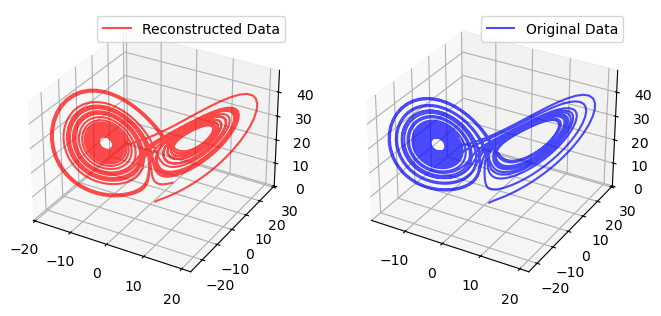

In [6]:
# 3D plot
fig = plt.figure(figsize=(16, 8))

# Original Data
ax = fig.add_subplot(211, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2], label='Original Data', color='blue', alpha=0.7)
ax.legend()

# Reconstructed Data
ax = fig.add_subplot(221, projection='3d')
ax.plot(simulated_data[:, 0], simulated_data[:, 1], simulated_data[:, 2], label='Reconstructed Data', color='red', alpha=0.7)
ax.legend()

### Task 1.3 Performance Measure

In [7]:
def predict_n_step(model, data, t, i, N):
    return model.simulate(data[i], t[i: i+N+1])[-1]

In [8]:
# Test time points
N = 1
num_values = [200, 500, 1000, 2000]

for num in num_values:
    # Predict points after N step
    predicted_points = np.array(Parallel(n_jobs=16)(delayed(predict_n_step)(model, sol.y.T, sol.t, i, N) for i in tqdm(range(num - N))))

    # Compute MSE
    mse = np.mean((predicted_points - sol.y.T[N: num]) ** 2)
    print(f"Number of time points = {num}: MSE = {mse}")

100%|██████████| 199/199 [00:01<00:00, 101.19it/s]


Number of time points = 200: MSE = 5.5800584789145325e-05


100%|██████████| 499/499 [00:00<00:00, 855.46it/s]


Number of time points = 500: MSE = 2.5767475246301933e-05


100%|██████████| 999/999 [00:01<00:00, 699.09it/s]


Number of time points = 1000: MSE = 2.1603153260051547e-05


100%|██████████| 1999/1999 [00:03<00:00, 651.01it/s]


Number of time points = 2000: MSE = 2.8534729808990975e-05


In case the analysis takes too long, it needs 1000 time points to be computed to achieve reasonably low variance.

In [9]:
# Test N values
N_values = [1, 5, 10, 20, 50]
num = 1000

for N in N_values:
    # Predict points after N step
    predicted_points = np.array(Parallel(n_jobs=16)(delayed(predict_n_step)(model, sol.y.T, sol.t, i, N) for i in tqdm(range(num - N))))

    # Compute MSE
    mse = np.mean((predicted_points - sol.y.T[N: num]) ** 2)
    print(f"N = {N}: MSE = {mse}")

100%|██████████| 999/999 [00:01<00:00, 714.65it/s]


N = 1: MSE = 2.1603153260051547e-05


100%|██████████| 995/995 [00:02<00:00, 361.20it/s]


N = 5: MSE = 0.0002909626632151381


100%|██████████| 990/990 [00:03<00:00, 261.63it/s]


N = 10: MSE = 0.000683610352922234


100%|██████████| 980/980 [00:05<00:00, 176.73it/s]


N = 20: MSE = 0.0019489739784875673


100%|██████████| 950/950 [00:10<00:00, 86.89it/s]


N = 50: MSE = 0.003691919070032218


Prediction errors increase significantly over time due to their sensitive dependence on initial conditions. For the Lorenz system, choosing $N=10$ is a practical choice for balancing predictability and computational efficiency.

### Task 1.4 Noise

In [10]:
def add_noise(data, noise_level):
    noisy_data = data + noise_level * np.random.randn(*data.shape)
    return noisy_data

In [11]:
noisy_data = add_noise(sol.y, 0.1)
thresholds = [0.005, 0.01, 0.02, 0.05]
N = 10

for threshold in thresholds:
    optimizer = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)
    model.fit(noisy_data.T, t=sol.t)
    print(f"Threshold: {threshold}")
    model.print()
    predicted_points = np.array(Parallel(n_jobs=16)(delayed(predict_n_step)(model, sol.y.T, sol.t, i, N) for i in tqdm(range(num - N))))
    mse = np.mean((predicted_points - sol.y.T[N: num]) ** 2)
    print(f"MSE: {mse}")

Threshold: 0.005
(x0)' = -9.972 x0 + 9.977 x1
(x1)' = 0.127 1 + 27.523 x0 + -0.890 x1 + -0.005 x2 + -0.986 x0 x2
(x2)' = 0.480 1 + -0.017 x0 + -2.687 x2 + 0.011 x0^2 + 0.981 x0 x1 + 0.006 x1^2


100%|██████████| 990/990 [00:04<00:00, 243.80it/s]


MSE: 0.0007423760618551104
Threshold: 0.01
(x0)' = -9.972 x0 + 9.977 x1
(x1)' = 27.527 x0 + -0.891 x1 + -0.986 x0 x2
(x2)' = 0.098 1 + -2.660 x2 + 0.996 x0 x1


100%|██████████| 990/990 [00:04<00:00, 237.32it/s]


MSE: 0.0007171731843752234
Threshold: 0.02
(x0)' = -9.972 x0 + 9.977 x1
(x1)' = 27.527 x0 + -0.891 x1 + -0.986 x0 x2
(x2)' = 0.098 1 + -2.660 x2 + 0.996 x0 x1


100%|██████████| 990/990 [00:04<00:00, 232.65it/s]


MSE: 0.0007171731843752234
Threshold: 0.05
(x0)' = -9.972 x0 + 9.977 x1
(x1)' = 27.527 x0 + -0.891 x1 + -0.986 x0 x2
(x2)' = 0.098 1 + -2.660 x2 + 0.996 x0 x1


100%|██████████| 990/990 [00:04<00:00, 225.32it/s]


MSE: 0.0007171731843752234


For the dataset with 10 percent noise, setting the threshold at 0.01 in the SINDy model proves sufficient. Increasing the threshold beyond this value does not result in lower prediction errors.

In [12]:
noisy_data = add_noise(sol.y, 0.2)
thresholds = [0.01, 0.02, 0.03, 0.05]
for threshold in thresholds:
    optimizer = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)
    model.fit(noisy_data.T, t=sol.t)
    print(f"Threshold: {threshold}")
    model.print()
    predicted_points = np.array(Parallel(n_jobs=16)(delayed(predict_n_step)(model, sol.y.T, sol.t, i, N) for i in tqdm(range(num - N))))
    mse = np.mean((predicted_points - sol.y.T[N: num]) ** 2)
    print(f"MSE: {mse}")

Threshold: 0.01
(x0)' = 0.050 1 + -9.920 x0 + 9.918 x1
(x1)' = -0.276 1 + 26.600 x0 + -0.326 x1 + -0.960 x0 x2 + -0.015 x1 x2
(x2)' = -0.158 1 + -2.655 x2 + 0.997 x0 x1


100%|██████████| 990/990 [00:04<00:00, 227.72it/s]


MSE: 0.001357680884399012
Threshold: 0.02
(x0)' = 0.050 1 + -9.920 x0 + 9.918 x1
(x1)' = -0.078 1 + 27.240 x0 + -0.808 x1 + -0.979 x0 x2
(x2)' = -0.158 1 + -2.655 x2 + 0.997 x0 x1


100%|██████████| 990/990 [00:04<00:00, 226.09it/s]


MSE: 0.001318773678040758
Threshold: 0.03
(x0)' = 0.050 1 + -9.920 x0 + 9.918 x1
(x1)' = -0.078 1 + 27.240 x0 + -0.808 x1 + -0.979 x0 x2
(x2)' = -0.158 1 + -2.655 x2 + 0.997 x0 x1


100%|██████████| 990/990 [00:04<00:00, 225.70it/s]


MSE: 0.001318773678040758
Threshold: 0.05
(x0)' = 0.050 1 + -9.920 x0 + 9.918 x1
(x1)' = -0.078 1 + 27.240 x0 + -0.808 x1 + -0.979 x0 x2
(x2)' = -0.158 1 + -2.655 x2 + 0.997 x0 x1


100%|██████████| 990/990 [00:04<00:00, 222.23it/s]


MSE: 0.001318773678040758


For the dataset with 20 percent noise, setting the threshold at 0.02 in the SINDy model proves sufficient. Increasing the threshold beyond this value does not result in lower prediction errors.

In [13]:
noisy_data = add_noise(sol.y, 0.5)
thresholds = [0.01, 0.05, 0.1, 0.2]
for threshold in thresholds:
    optimizer = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)
    model.fit(noisy_data.T, t=sol.t)
    print(f"Threshold: {threshold}")
    model.print()
    predicted_points = np.array(Parallel(n_jobs=16)(delayed(predict_n_step)(model, sol.y.T, sol.t, i, N) for i in tqdm(range(num - N))))
    mse = np.mean((predicted_points - sol.y.T[N: num]) ** 2)
    print(f"MSE: {mse}")

Threshold: 0.01
(x0)' = 2.428 1 + 6.386 x0 + 1.702 x1 + -0.279 x2 + -0.082 x0^2 + 0.067 x0 x1 + -0.579 x0 x2 + -0.013 x1^2 + 0.233 x1 x2 + 0.010 x2^2 + 0.054 x0^3 + -0.047 x0^2 x1 + 0.012 x0 x1^2
(x1)' = -0.332 1 + 25.184 x0 + 0.495 x1 + -0.022 x2 + -0.923 x0 x2 + -0.035 x1 x2
(x2)' = 3.952 1 + 0.012 x1 + -3.307 x2 + -0.132 x0^2 + 1.073 x0 x1 + 0.024 x2^2


100%|██████████| 990/990 [00:04<00:00, 243.94it/s]


MSE: 0.022799404677391947
Threshold: 0.05
(x0)' = 1.189 1 + -5.446 x0 + 7.343 x1 + -0.114 x0 x2 + 0.057 x1 x2
(x1)' = -0.447 1 + 26.583 x0 + -0.583 x1 + -0.965 x0 x2
(x2)' = 0.192 1 + -2.644 x2 + 0.988 x0 x1


100%|██████████| 990/990 [00:04<00:00, 239.22it/s]


MSE: 0.015584748307172191
Threshold: 0.1
(x0)' = -9.505 x0 + 9.559 x1
(x1)' = -0.447 1 + 26.583 x0 + -0.583 x1 + -0.965 x0 x2
(x2)' = 0.192 1 + -2.644 x2 + 0.988 x0 x1


100%|██████████| 990/990 [00:04<00:00, 233.54it/s]


MSE: 0.00789167712585458
Threshold: 0.2
(x0)' = -9.505 x0 + 9.559 x1
(x1)' = -9.813 1 + -6.691 x0 + 20.359 x1 + -0.606 x1 x2
(x2)' = -2.636 x2 + 0.988 x0 x1


100%|██████████| 990/990 [00:04<00:00, 227.28it/s]


MSE: 1.261616320524987


For the dataset with 50 percent noise, setting the threshold at 0.1 in the SINDy model proves sufficient. Increasing the threshold beyond this value does not result in lower prediction errors.

The analysis indicates that noisier datasets require higher thresholds in the SINDy model to optimize accuracy and manage overfitting. This approach helps to ensure the model captures only the most significant dynamics, essential for maintaining robustness in noisy environments.

### Task 1.5 Partial Observation

In [14]:
def embed_time_series(data, t, delay, dimension):
    n_samples = len(data) - (dimension - 1) * delay
    embedded_data = np.zeros((n_samples, dimension))
    for i in range(dimension):
        embedded_data[:, i] = data[i * delay:i * delay + n_samples]
    return embedded_data, t[:n_samples]

In [16]:
for delay_time in [5, 10, 20]:
    for embedding_dim in [2, 3, 4]:
        print(f'Delay: {delay_time}, Dimension: {embedding_dim}')
        embedded_x, t = embed_time_series(sol.y[0], sol.t, delay_time, embedding_dim)

        optimizer = ps.STLSQ(threshold=0.1)
        model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)
        model.fit(embedded_x, t=t)
        model.print()

        predicted_points = np.array(Parallel(n_jobs=16)(delayed(predict_n_step)(model, embedded_x, sol.t, i, N) for i in tqdm(range(num - N))))
        mse = np.mean((predicted_points[:, 0] - embedded_x[N: num, 0]) ** 2)
        print(f"MSE: {mse}")

Delay: 5, Dimension: 2
(x0)' = -19.123 x0 + 19.630 x1
(x1)' = -19.657 x0 + 19.151 x1


100%|██████████| 990/990 [00:01<00:00, 924.47it/s]


MSE: 0.5800677451970786
Delay: 5, Dimension: 3
(x0)' = -27.539 x0 + 37.274 x1 + -9.694 x2
(x1)' = -10.522 x0 + 10.521 x2
(x2)' = 9.882 x0 + -37.632 x1 + 27.712 x2 + -0.376 x0 x1 + 0.447 x0 x2 + 0.737 x1^2 + -1.215 x1 x2 + 0.407 x2^2


100%|██████████| 990/990 [00:03<00:00, 269.09it/s]


MSE: 0.0008239871428475813
Delay: 5, Dimension: 4
(x0)' = -32.315 x0 + 51.085 x1 + -24.585 x2 + 5.909 x3
(x1)' = -7.706 x0 + -8.148 x1 + 19.313 x2 + -3.492 x3
(x2)' = -10.522 x1 + 10.521 x3
(x3)' = -5.922 x0 + 24.618 x1 + -51.119 x2 + 32.328 x3


100%|██████████| 990/990 [00:08<00:00, 121.15it/s]


MSE: 0.001416113280094231
Delay: 10, Dimension: 2
(x0)' = -8.458 x0 + 9.352 x1
(x1)' = -9.386 x0 + 8.495 x1


100%|██████████| 990/990 [00:01<00:00, 924.96it/s]


MSE: 0.055372009026535315
Delay: 10, Dimension: 3
(x0)' = 0.462 1 + -11.046 x0 + 15.969 x1 + -4.578 x2 + -0.123 x0^2 + 0.453 x0 x1 + -0.150 x0 x2 + -0.313 x1^2 + 0.158 x1 x2
(x1)' = -5.942 x0 + 5.939 x2
(x2)' = 4.590 x0 + -15.913 x1 + 11.123 x2


100%|██████████| 990/990 [00:03<00:00, 273.52it/s]


MSE: 0.017023382376993378
Delay: 10, Dimension: 4
(x0)' = -9.298 x0 + 11.339 x1 + -1.723 x3
(x1)' = -5.939 x0 + 5.939 x2
(x2)' = -5.952 x1 + 5.955 x3
(x3)' = -2.442 x0 + 8.479 x1 + -18.751 x2 + 12.057 x3 + -0.242 x0 x2 + 0.147 x1 x2 + 0.148 x1 x3 + -0.117 x2 x3


100%|██████████| 990/990 [00:08<00:00, 123.32it/s]


MSE: 0.21863593115995208
Delay: 20, Dimension: 2
(x0)' = 5.048 1 + -2.547 x0 + 3.978 x1
(x1)' = -5.432 1 + -3.995 x0 + 2.547 x1


100%|██████████| 990/990 [00:01<00:00, 944.54it/s]


MSE: 2.0875362141484954
Delay: 20, Dimension: 3
(x0)' = 2.185 1 + -2.776 x0 + 5.238 x1 + -1.780 x2
(x1)' = -2.883 x0 + 8.127 x1 + 0.955 x2 + -0.101 x0 x1^2
(x2)' = -3.329 1 + 1.717 x0 + -5.206 x1 + 2.699 x2


100%|██████████| 990/990 [00:04<00:00, 233.98it/s]


MSE: 1.538069985365878
Delay: 20, Dimension: 4
(x0)' = 0.687 1 + -2.588 x0 + 5.318 x1 + -1.986 x2 + 0.530 x3 + 0.116 x0 x2
(x1)' = 11.113 1 + -3.275 x0 + 9.203 x1 + 0.365 x2 + -0.259 x3 + -0.229 x0 x1 + -0.136 x2 x3 + -0.116 x0 x1^2
(x2)' = -0.118 1 + -3.483 x1 + -0.188 x2 + 3.659 x3
(x3)' = 3.510 1 + 1.323 x1 + -4.079 x2 + 9.880 x3 + -0.131 x2 x3 + -0.118 x2 x3^2


100%|██████████| 990/990 [00:09<00:00, 103.69it/s]


MSE: 1.4153507915518906


The best results were achieved using a delay of 5 and an embedding dimension of 4, yielding a MSE of 0.0008. This setup optimally captured the system's dynamics, leading to high model accuracy.

### Task 1.6 Low Data Limit

In [17]:
num = 1000
data_sizes = [1000, 1500, 2000, 2500, 3000]
for size in data_sizes:
    sampled_data = sol.y.T[:size]
    sampled_t = sol.t[:size]
    
    optimizer = ps.STLSQ(threshold=0.1)
    model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)
    model.fit(sampled_data, t=sampled_t)
    print(size)
    model.print()
    predicted_points = np.array(Parallel(n_jobs=16)(delayed(predict_n_step)(model, sampled_data, sampled_t, i, N) for i in tqdm(range(num - N))))
    mse = np.mean((predicted_points - sampled_data[N: num]) ** 2)
    print(f"MSE: {mse}")

1000
(x0)' = 9.381 1 + 4.149 x1 + -0.261 x0 x2 + 0.153 x1 x2
(x1)' = 27.484 x0 + -0.896 x1 + -0.984 x0 x2
(x2)' = 0.228 1 + -2.665 x2 + 0.995 x0 x1


100%|██████████| 990/990 [00:03<00:00, 257.32it/s]


MSE: 0.01709221294503908
1500
(x0)' = -9.984 x0 + 9.984 x1
(x1)' = 27.532 x0 + -0.907 x1 + -0.986 x0 x2
(x2)' = -2.659 x2 + 0.996 x0 x1


100%|██████████| 990/990 [00:04<00:00, 242.83it/s]


MSE: 0.0007343952542647088
2000
(x0)' = -9.983 x0 + 9.984 x1
(x1)' = 27.572 x0 + -0.914 x1 + -0.987 x0 x2
(x2)' = -2.659 x2 + 0.996 x0 x1


100%|██████████| 990/990 [00:04<00:00, 238.73it/s]


MSE: 0.000677346975528092
2500
(x0)' = -9.983 x0 + 9.983 x1
(x1)' = 27.576 x0 + -0.913 x1 + -0.987 x0 x2
(x2)' = -2.659 x2 + 0.996 x0 x1


100%|██████████| 990/990 [00:04<00:00, 241.27it/s]


MSE: 0.0006745349491226786
3000
(x0)' = -9.983 x0 + 9.983 x1
(x1)' = 27.561 x0 + -0.909 x1 + -0.987 x0 x2
(x2)' = -2.659 x2 + 0.996 x0 x1


100%|██████████| 990/990 [00:04<00:00, 234.06it/s]


MSE: 0.000683610352922234


The minimal number of time points required to faithfully reconstruct the Lorenz system is determined to be 1,500.

### Task 1.7 Logistic Map

In [9]:
def logistic_map(r, x):
    return r * x * (1 - x)

def simulate_logistic_map(r_values, num_iterations, initial_value=0.5):
    data = np.zeros((len(r_values), num_iterations))
    for i, r in enumerate(r_values):
        x = initial_value
        for t in range(num_iterations):
            x = logistic_map(r, x)
            data[i, t] = x
    return data

r_values = np.linspace(1.0, 4.0, 1001, endpoint=False)[1:]
logistic_data = simulate_logistic_map(r_values, 20000)

Text(0, 0.5, '$x$')

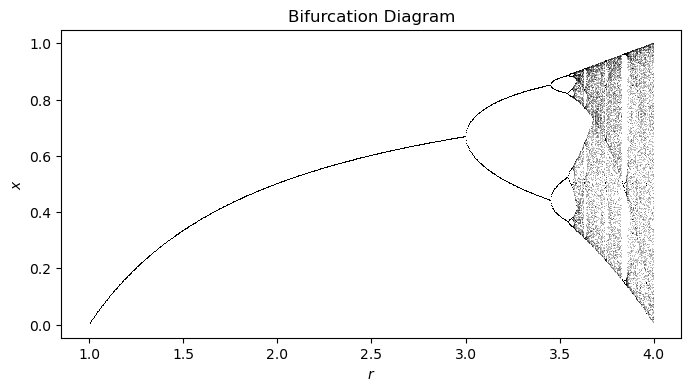

In [10]:
plt.figure(figsize=(8, 4))
for i in range(len(r_values)):
    plt.plot([r_values[i]] * 100, logistic_data[i, -100:], ',k', alpha=0.25)
plt.title("Bifurcation Diagram")
plt.xlabel("$r$")
plt.ylabel("$x$")

In [11]:
library = ps.PolynomialLibrary(degree=2, include_bias=False, include_interaction=False)
optimizer = ps.STLSQ(threshold=0.5, alpha=0.01)
model = ps.SINDy(feature_library=library, optimizer=optimizer, discrete_time=True)

coef = []
for trajectory in logistic_data:
    X_current = np.array(trajectory[-3000:])
    model.fit(X_current.reshape(-1,1))
    coef.append(model.coefficients()[0])
coef = np.array(coef).T

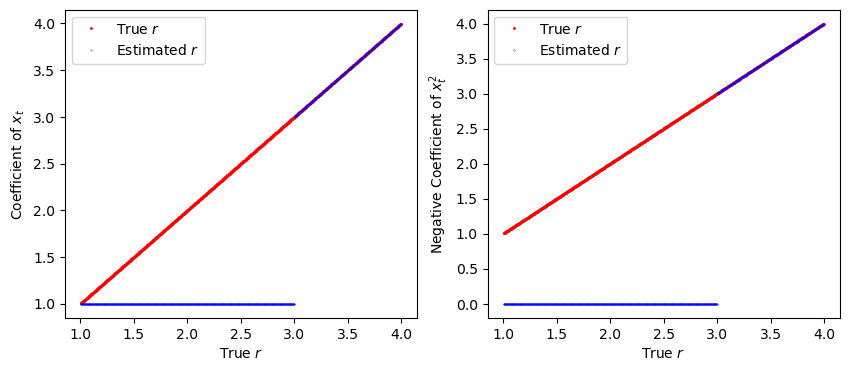

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(r_values, r_values, 'r.', markersize=2, label='True $r$')
axes[0].plot(r_values, coef[0], 'b.', markersize=0.5, label='Estimated $r$')
axes[0].set_xlabel('True $r$')
axes[0].set_ylabel('Coefficient of $x_t$')
axes[0].legend()

axes[1].plot(r_values, r_values, 'r.', markersize=2, label='True $r$')
axes[1].plot(r_values, -coef[1], 'b.', markersize=0.5, label='Estimated $r$')
axes[1].set_xlabel('True $r$')
axes[1].set_ylabel('Negative Coefficient of $x_t^2$')
axes[1].legend()

The analysis of the SINDy model outputs for the logistic map shows distinct behaviors depending on the value of $ r $.

- For $ r $ values less than 3, where the map converges to a fixed point, the SINDy model essentially finds that $ x_{t+1} = x_t $. This indicates stability at the fixed points, making it challenging to estimate $ r $ because the dynamical changes are minimal and don't effectively highlight the role of $ r $ in driving the system's behavior.

- For $ r $ values greater than 3, where the system exhibits more complex dynamics including cycles and chaotic behavior, the SINDy model is able to capture and estimate the parameters effectively. In this regime, the model identifies coefficients $ a $ and $ b $ from the learned quadratic equation $ a x_t - b x_t^2 $, both of which correlate with $ r $ and can be used to accurately estimate its value.